# Train and Evaluate ORCNN on amodal and visible masks

In [1]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os
import cv2
import random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog,MetadataCatalog
from detectron2.engine import DefaultTrainer
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 10,10
def imshow(img):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")
    plt.show()
    
# run on gpu 0 (NVIDIA Geforce GTX 1080Ti) and gpu 1 (NVIDIA Geforce GTX 1070Ti)
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

## Register the amodal datasets 

In [2]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("broccoli_amodal_train", {}, "datasets/train_val_test_files/orcnn/train/annotations.json", "datasets/train_val_test_files/orcnn/train")
register_coco_instances("broccoli_amodal_val", {}, "datasets/train_val_test_files/orcnn/val/annotations.json", "datasets/train_val_test_files/orcnn/val")
register_coco_instances("broccoli_amodal_test", {}, "datasets/train_val_test_files/orcnn/test/annotations.json", "datasets/train_val_test_files/orcnn/test")

In [3]:
broccoli_amodal_train_metadata = MetadataCatalog.get("broccoli_amodal_train")
print(broccoli_amodal_train_metadata)

broccoli_amodal_val_metadata = MetadataCatalog.get("broccoli_amodal_val")
print(broccoli_amodal_val_metadata)

broccoli_amodal_test_metadata = MetadataCatalog.get("broccoli_amodal_test")
print(broccoli_amodal_test_metadata)

Metadata(evaluator_type='coco', image_root='datasets/train_val_test_files/orcnn/train', json_file='datasets/train_val_test_files/orcnn/train/annotations.json', name='broccoli_amodal_train')
Metadata(evaluator_type='coco', image_root='datasets/train_val_test_files/orcnn/val', json_file='datasets/train_val_test_files/orcnn/val/annotations.json', name='broccoli_amodal_val')
Metadata(evaluator_type='coco', image_root='datasets/train_val_test_files/orcnn/test', json_file='datasets/train_val_test_files/orcnn/test/annotations.json', name='broccoli_amodal_test')


In [4]:
dataset_dicts_train = DatasetCatalog.get("broccoli_amodal_train")
dataset_dicts_val = DatasetCatalog.get("broccoli_amodal_val")
dataset_dicts_test = DatasetCatalog.get("broccoli_amodal_test")

[11/09 11:58:50 d2.data.datasets.coco]: Loaded 1569 images in COCO format from datasets/train_val_test_files/orcnn/train/annotations.json
[11/09 11:58:50 d2.data.datasets.coco]: Loaded 504 images in COCO format from datasets/train_val_test_files/orcnn/val/annotations.json
[11/09 11:58:50 d2.data.datasets.coco]: Loaded 487 images in COCO format from datasets/train_val_test_files/orcnn/test/annotations.json


## Visualize the amodal masks 

datasets/train_val_test_files/orcnn/train/PNGImages/20200713_152816197943_plant1084_rgb_trigger003.png


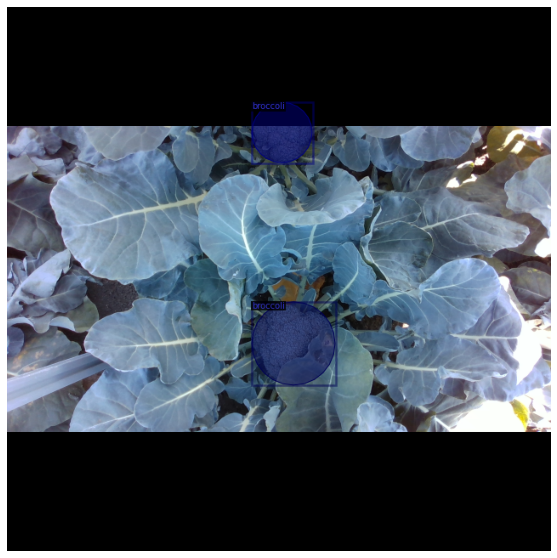

datasets/train_val_test_files/orcnn/train/PNGImages/3540_Untrimmed_Frame_8_133_rgb.png


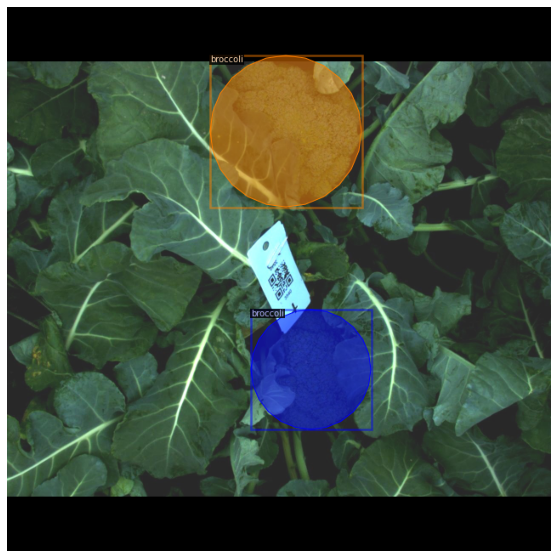

datasets/train_val_test_files/orcnn/train/PNGImages/184_Untrimmed_Frame_1_158_rgb.png


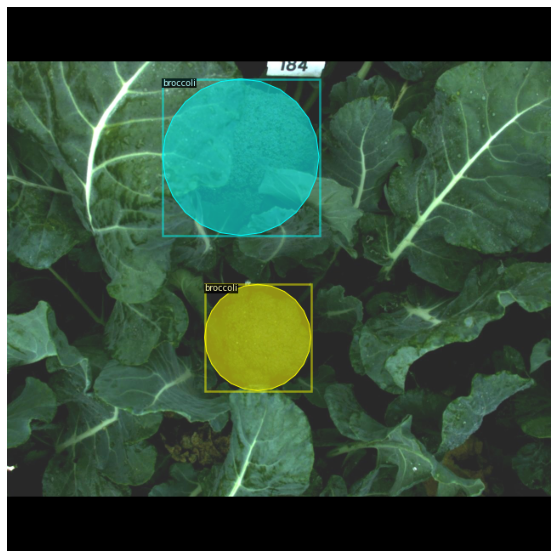

In [5]:
for d in random.sample(dataset_dicts_train, 3):
    img = cv2.imread(d["file_name"])
    print(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=broccoli_amodal_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d, segm='segmentation')
    imshow(vis.get_image()[:, :, ::-1])

## Visualize the visible masks

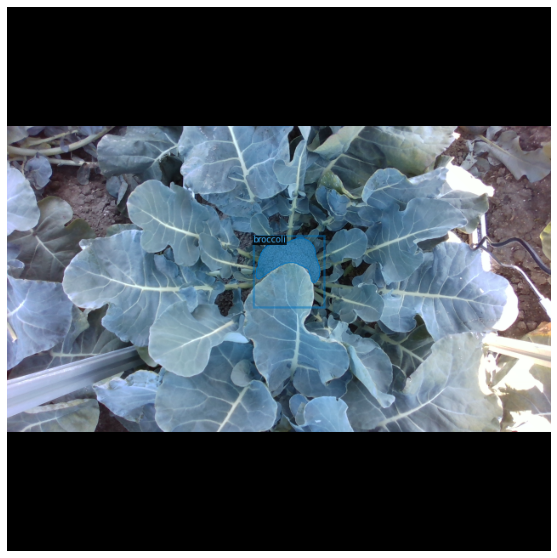

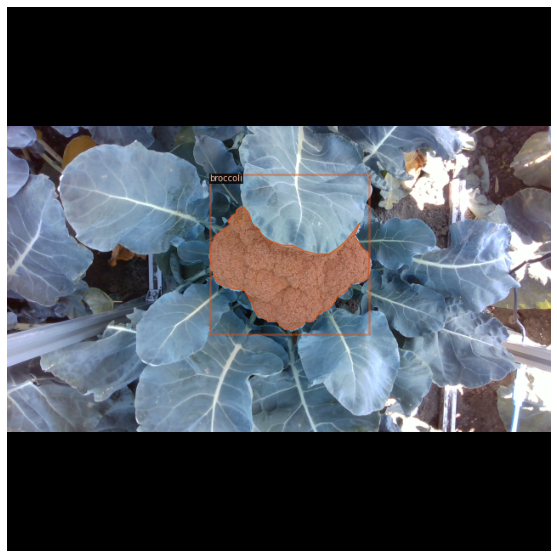

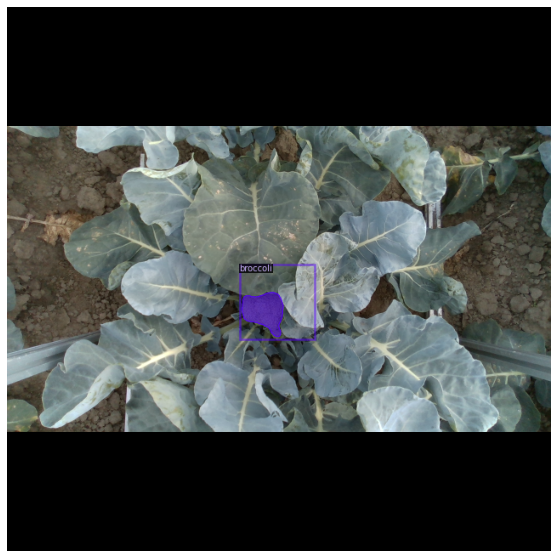

In [6]:
for d in random.sample(dataset_dicts_train, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=broccoli_amodal_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d, segm='visible_mask')
    imshow(vis.get_image()[:, :, ::-1])

## Initialize the training and inference parameters

In [7]:
# thanks to: https://medium.com/@apofeniaco/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e
# thanks to: https://colab.research.google.com/drive/1-TNOcPm3Jr3fOJG8rnGT9gh60mHUsvaW#scrollTo=B4UESNQ4tyVm
# code extracted from: https://gist.github.com/ortegatron/c0dad15e49c2b74de8bb09a5615d9f6b

from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
import torch
import time
import datetime
import logging

class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
        
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)

In [8]:
from detectron2.evaluation import AmodalEvaluator

class AmodalTrainer(DefaultTrainer):
    
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return AmodalEvaluator(dataset_name, cfg, False, output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            20,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks

In [9]:
import os
import numpy as np
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_orcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("broccoli_amodal_train",)
cfg.DATASETS.TEST = ("broccoli_amodal_val",)

cfg.NUM_GPUS = 2
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")

# solver file settings extracted from: https://github.com/facebookresearch/Detectron/blob/master/configs/04_2018_gn_baselines/scratch_e2e_mask_rcnn_R-101-FPN_3x_gn.yaml
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.WEIGHT_DECAY = 0.0001
cfg.SOLVER.LR_POLICY = 'steps_with_decay'
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.GAMMA = 0.1
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 15000
cfg.SOLVER.STEPS = (0, 7000, 11000)
cfg.SOLVER.CHECKPOINT_PERIOD = 1000

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (broccoli)

# https://medium.com/@apofeniaco/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e
cfg.OUTPUT_DIR = "weights/20201109_broccoli_amodal_visible"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = AmodalTrainer(cfg) 

[11/09 11:59:26 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[11/09 11:59:27 d2.data.datasets.coco]: Loaded 1569 images in COCO format from datasets/train_val_test_files/orcnn/train/annotations.json
[11/09 11:59:27 d2.data.build]: Removed 0 images with no usable annotations. 1569 images left.
[11/09 11:59:27 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  broccoli  | 2197         |
|            |              |
[11/09 11:59:27 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[11/09 11:59:27 d2.data.build]: Using training sampler TrainingSampler
[11/09 11:59:27 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[11/09 11:59:27 d2.data.datasets.coco]: Loaded 504 images in COCO format from datasets/train_val_tes

## Start the training 

In [10]:
trainer.resume_or_load(resume=False)
trainer.train()

[11/09 11:59:32 d2.engine.train_loop]: Starting training from iteration 0
[11/09 12:00:46 d2.utils.events]: eta: 2:43:35  iter: 19  total_loss: 2.450  loss_cls: 0.696  loss_box_reg: 0.313  loss_amodal_mask: 0.687  loss_visible_mask: 0.693  loss_rpn_cls: 0.040  loss_rpn_loc: 0.007  validation_loss: 2.182  time: 0.6564  data_time: 0.0090  lr: 0.000040  max_mem: 4302M
[11/09 12:02:01 d2.utils.events]: eta: 2:41:06  iter: 39  total_loss: 1.928  loss_cls: 0.270  loss_box_reg: 0.267  loss_amodal_mask: 0.644  loss_visible_mask: 0.693  loss_rpn_cls: 0.065  loss_rpn_loc: 0.006  validation_loss: 2.042  time: 0.6380  data_time: 0.0025  lr: 0.000080  max_mem: 4497M
[11/09 12:03:18 d2.utils.events]: eta: 2:44:21  iter: 59  total_loss: 1.780  loss_cls: 0.185  loss_box_reg: 0.309  loss_amodal_mask: 0.566  loss_visible_mask: 0.691  loss_rpn_cls: 0.011  loss_rpn_loc: 0.007  validation_loss: 1.902  time: 0.6629  data_time: 0.0025  lr: 0.000120  max_mem: 4541M
[11/09 12:04:33 d2.utils.events]: eta: 2:42:

[11/09 12:34:14 d2.utils.events]: eta: 2:35:36  iter: 559  total_loss: 0.647  loss_cls: 0.051  loss_box_reg: 0.187  loss_amodal_mask: 0.244  loss_visible_mask: 0.146  loss_rpn_cls: 0.000  loss_rpn_loc: 0.005  validation_loss: 0.754  time: 0.6412  data_time: 0.0026  lr: 0.001119  max_mem: 4642M
[11/09 12:35:30 d2.utils.events]: eta: 2:35:54  iter: 579  total_loss: 0.583  loss_cls: 0.045  loss_box_reg: 0.192  loss_amodal_mask: 0.229  loss_visible_mask: 0.150  loss_rpn_cls: 0.000  loss_rpn_loc: 0.004  validation_loss: 0.719  time: 0.6422  data_time: 0.0028  lr: 0.001159  max_mem: 4642M
[11/09 12:36:44 d2.utils.events]: eta: 2:35:41  iter: 599  total_loss: 0.623  loss_cls: 0.043  loss_box_reg: 0.175  loss_amodal_mask: 0.243  loss_visible_mask: 0.143  loss_rpn_cls: 0.000  loss_rpn_loc: 0.004  validation_loss: 0.661  time: 0.6419  data_time: 0.0031  lr: 0.001199  max_mem: 4642M
[11/09 12:37:59 d2.utils.events]: eta: 2:35:28  iter: 619  total_loss: 0.699  loss_cls: 0.068  loss_box_reg: 0.201 

[11/09 13:08:10 d2.utils.events]: eta: 2:30:59  iter: 1099  total_loss: 0.550  loss_cls: 0.053  loss_box_reg: 0.209  loss_amodal_mask: 0.173  loss_visible_mask: 0.096  loss_rpn_cls: 0.000  loss_rpn_loc: 0.005  validation_loss: 0.558  time: 0.6442  data_time: 0.0026  lr: 0.002000  max_mem: 4773M
[11/09 13:09:26 d2.utils.events]: eta: 2:30:56  iter: 1119  total_loss: 0.587  loss_cls: 0.063  loss_box_reg: 0.194  loss_amodal_mask: 0.203  loss_visible_mask: 0.091  loss_rpn_cls: 0.001  loss_rpn_loc: 0.004  validation_loss: 0.558  time: 0.6447  data_time: 0.0025  lr: 0.002000  max_mem: 4773M
[11/09 13:10:42 d2.utils.events]: eta: 2:30:50  iter: 1139  total_loss: 0.436  loss_cls: 0.036  loss_box_reg: 0.115  loss_amodal_mask: 0.163  loss_visible_mask: 0.090  loss_rpn_cls: 0.001  loss_rpn_loc: 0.003  validation_loss: 0.554  time: 0.6450  data_time: 0.0024  lr: 0.002000  max_mem: 4773M
[11/09 13:11:58 d2.utils.events]: eta: 2:30:39  iter: 1159  total_loss: 0.488  loss_cls: 0.044  loss_box_reg: 0.

[11/09 13:42:44 d2.utils.events]: eta: 2:27:20  iter: 1639  total_loss: 0.444  loss_cls: 0.047  loss_box_reg: 0.173  loss_amodal_mask: 0.167  loss_visible_mask: 0.073  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  validation_loss: 0.536  time: 0.6494  data_time: 0.0025  lr: 0.002000  max_mem: 4846M
[11/09 13:44:00 d2.utils.events]: eta: 2:27:05  iter: 1659  total_loss: 0.401  loss_cls: 0.038  loss_box_reg: 0.119  loss_amodal_mask: 0.158  loss_visible_mask: 0.074  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.536  time: 0.6494  data_time: 0.0024  lr: 0.002000  max_mem: 4846M
[11/09 13:45:17 d2.utils.events]: eta: 2:26:51  iter: 1679  total_loss: 0.465  loss_cls: 0.048  loss_box_reg: 0.162  loss_amodal_mask: 0.160  loss_visible_mask: 0.072  loss_rpn_cls: 0.001  loss_rpn_loc: 0.004  validation_loss: 0.536  time: 0.6496  data_time: 0.0026  lr: 0.002000  max_mem: 4846M
[11/09 13:46:34 d2.utils.events]: eta: 2:26:40  iter: 1699  total_loss: 0.437  loss_cls: 0.047  loss_box_reg: 0.

[11/09 14:17:27 d2.utils.events]: eta: 2:22:41  iter: 2179  total_loss: 0.434  loss_cls: 0.049  loss_box_reg: 0.148  loss_amodal_mask: 0.153  loss_visible_mask: 0.066  loss_rpn_cls: 0.000  loss_rpn_loc: 0.004  validation_loss: 0.501  time: 0.6522  data_time: 0.0031  lr: 0.002000  max_mem: 4846M
[11/09 14:18:44 d2.utils.events]: eta: 2:22:31  iter: 2199  total_loss: 0.388  loss_cls: 0.039  loss_box_reg: 0.132  loss_amodal_mask: 0.142  loss_visible_mask: 0.067  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  validation_loss: 0.501  time: 0.6522  data_time: 0.0026  lr: 0.002000  max_mem: 4846M
[11/09 14:20:01 d2.utils.events]: eta: 2:22:13  iter: 2219  total_loss: 0.336  loss_cls: 0.027  loss_box_reg: 0.109  loss_amodal_mask: 0.120  loss_visible_mask: 0.065  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  validation_loss: 0.501  time: 0.6522  data_time: 0.0027  lr: 0.002000  max_mem: 4846M
[11/09 14:21:18 d2.utils.events]: eta: 2:22:14  iter: 2239  total_loss: 0.438  loss_cls: 0.053  loss_box_reg: 0.

[11/09 14:52:04 d2.utils.events]: eta: 2:16:36  iter: 2719  total_loss: 0.472  loss_cls: 0.046  loss_box_reg: 0.167  loss_amodal_mask: 0.162  loss_visible_mask: 0.062  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  validation_loss: 0.494  time: 0.6533  data_time: 0.0023  lr: 0.002000  max_mem: 4876M
[11/09 14:53:21 d2.utils.events]: eta: 2:16:40  iter: 2739  total_loss: 0.417  loss_cls: 0.038  loss_box_reg: 0.152  loss_amodal_mask: 0.151  loss_visible_mask: 0.060  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  validation_loss: 0.498  time: 0.6534  data_time: 0.0026  lr: 0.002000  max_mem: 4876M
[11/09 14:54:37 d2.utils.events]: eta: 2:16:33  iter: 2759  total_loss: 0.383  loss_cls: 0.037  loss_box_reg: 0.134  loss_amodal_mask: 0.138  loss_visible_mask: 0.061  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  validation_loss: 0.498  time: 0.6534  data_time: 0.0025  lr: 0.002000  max_mem: 4876M
[11/09 14:55:55 d2.utils.events]: eta: 2:16:25  iter: 2779  total_loss: 0.411  loss_cls: 0.042  loss_box_reg: 0.

[11/09 15:26:40 d2.utils.events]: eta: 2:09:55  iter: 3259  total_loss: 0.313  loss_cls: 0.029  loss_box_reg: 0.105  loss_amodal_mask: 0.109  loss_visible_mask: 0.059  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.485  time: 0.6537  data_time: 0.0024  lr: 0.002000  max_mem: 4876M
[11/09 15:27:57 d2.utils.events]: eta: 2:09:35  iter: 3279  total_loss: 0.324  loss_cls: 0.040  loss_box_reg: 0.103  loss_amodal_mask: 0.111  loss_visible_mask: 0.060  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.487  time: 0.6536  data_time: 0.0027  lr: 0.002000  max_mem: 4876M
[11/09 15:29:14 d2.utils.events]: eta: 2:09:24  iter: 3299  total_loss: 0.334  loss_cls: 0.035  loss_box_reg: 0.104  loss_amodal_mask: 0.128  loss_visible_mask: 0.067  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.487  time: 0.6537  data_time: 0.0026  lr: 0.002000  max_mem: 4876M
[11/09 15:30:31 d2.utils.events]: eta: 2:09:12  iter: 3319  total_loss: 0.348  loss_cls: 0.030  loss_box_reg: 0.

[11/09 16:01:16 d2.utils.events]: eta: 2:03:26  iter: 3799  total_loss: 0.324  loss_cls: 0.030  loss_box_reg: 0.120  loss_amodal_mask: 0.111  loss_visible_mask: 0.061  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  validation_loss: 0.463  time: 0.6541  data_time: 0.0026  lr: 0.002000  max_mem: 4876M
[11/09 16:02:33 d2.utils.events]: eta: 2:03:15  iter: 3819  total_loss: 0.320  loss_cls: 0.036  loss_box_reg: 0.127  loss_amodal_mask: 0.107  loss_visible_mask: 0.049  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.463  time: 0.6541  data_time: 0.0026  lr: 0.002000  max_mem: 4876M
[11/09 16:03:50 d2.utils.events]: eta: 2:03:00  iter: 3839  total_loss: 0.352  loss_cls: 0.037  loss_box_reg: 0.125  loss_amodal_mask: 0.129  loss_visible_mask: 0.054  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.463  time: 0.6541  data_time: 0.0025  lr: 0.002000  max_mem: 4876M
[11/09 16:05:08 d2.utils.events]: eta: 2:02:52  iter: 3859  total_loss: 0.372  loss_cls: 0.037  loss_box_reg: 0.

[11/09 16:35:57 d2.utils.events]: eta: 1:57:42  iter: 4339  total_loss: 0.356  loss_cls: 0.034  loss_box_reg: 0.116  loss_amodal_mask: 0.134  loss_visible_mask: 0.048  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.486  time: 0.6546  data_time: 0.0026  lr: 0.002000  max_mem: 4876M
[11/09 16:37:14 d2.utils.events]: eta: 1:57:25  iter: 4359  total_loss: 0.314  loss_cls: 0.031  loss_box_reg: 0.142  loss_amodal_mask: 0.103  loss_visible_mask: 0.062  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  validation_loss: 0.482  time: 0.6546  data_time: 0.0025  lr: 0.002000  max_mem: 4876M
[11/09 16:38:30 d2.utils.events]: eta: 1:57:15  iter: 4379  total_loss: 0.297  loss_cls: 0.026  loss_box_reg: 0.108  loss_amodal_mask: 0.105  loss_visible_mask: 0.050  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.482  time: 0.6545  data_time: 0.0027  lr: 0.002000  max_mem: 4876M
[11/09 16:39:47 d2.utils.events]: eta: 1:57:03  iter: 4399  total_loss: 0.282  loss_cls: 0.028  loss_box_reg: 0.

[11/09 17:10:32 d2.utils.events]: eta: 1:51:35  iter: 4879  total_loss: 0.305  loss_cls: 0.030  loss_box_reg: 0.107  loss_amodal_mask: 0.111  loss_visible_mask: 0.055  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.471  time: 0.6543  data_time: 0.0025  lr: 0.002000  max_mem: 4876M
[11/09 17:11:48 d2.utils.events]: eta: 1:51:27  iter: 4899  total_loss: 0.299  loss_cls: 0.027  loss_box_reg: 0.094  loss_amodal_mask: 0.099  loss_visible_mask: 0.051  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.469  time: 0.6543  data_time: 0.0025  lr: 0.002000  max_mem: 4876M
[11/09 17:13:05 d2.utils.events]: eta: 1:51:12  iter: 4919  total_loss: 0.317  loss_cls: 0.031  loss_box_reg: 0.129  loss_amodal_mask: 0.109  loss_visible_mask: 0.050  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  validation_loss: 0.471  time: 0.6543  data_time: 0.0026  lr: 0.002000  max_mem: 4876M
[11/09 17:14:22 d2.utils.events]: eta: 1:51:03  iter: 4939  total_loss: 0.311  loss_cls: 0.026  loss_box_reg: 0.

[11/09 17:45:15 d2.utils.events]: eta: 1:45:48  iter: 5419  total_loss: 0.325  loss_cls: 0.036  loss_box_reg: 0.128  loss_amodal_mask: 0.105  loss_visible_mask: 0.053  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  validation_loss: 0.479  time: 0.6548  data_time: 0.0025  lr: 0.002000  max_mem: 4876M
[11/09 17:46:32 d2.utils.events]: eta: 1:45:31  iter: 5439  total_loss: 0.299  loss_cls: 0.025  loss_box_reg: 0.099  loss_amodal_mask: 0.096  loss_visible_mask: 0.050  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.479  time: 0.6548  data_time: 0.0027  lr: 0.002000  max_mem: 4876M
[11/09 17:47:49 d2.utils.events]: eta: 1:45:20  iter: 5459  total_loss: 0.322  loss_cls: 0.032  loss_box_reg: 0.119  loss_amodal_mask: 0.112  loss_visible_mask: 0.053  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.480  time: 0.6548  data_time: 0.0026  lr: 0.002000  max_mem: 4876M
[11/09 17:49:06 d2.utils.events]: eta: 1:45:03  iter: 5479  total_loss: 0.345  loss_cls: 0.034  loss_box_reg: 0.

[11/09 18:19:56 d2.utils.events]: eta: 1:39:45  iter: 5959  total_loss: 0.298  loss_cls: 0.025  loss_box_reg: 0.101  loss_amodal_mask: 0.098  loss_visible_mask: 0.060  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.477  time: 0.6549  data_time: 0.0026  lr: 0.002000  max_mem: 4876M
[11/09 18:21:13 d2.utils.events]: eta: 1:39:30  iter: 5979  total_loss: 0.264  loss_cls: 0.023  loss_box_reg: 0.093  loss_amodal_mask: 0.096  loss_visible_mask: 0.052  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.476  time: 0.6549  data_time: 0.0026  lr: 0.002000  max_mem: 4876M
[11/09 18:22:31 d2.utils.events]: eta: 1:39:28  iter: 5999  total_loss: 0.307  loss_cls: 0.025  loss_box_reg: 0.114  loss_amodal_mask: 0.103  loss_visible_mask: 0.047  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.476  time: 0.6549  data_time: 0.0027  lr: 0.002000  max_mem: 4876M
[11/09 18:23:49 d2.utils.events]: eta: 1:39:17  iter: 6019  total_loss: 0.253  loss_cls: 0.021  loss_box_reg: 0.

[11/09 18:54:45 d2.utils.events]: eta: 1:34:06  iter: 6499  total_loss: 0.266  loss_cls: 0.025  loss_box_reg: 0.111  loss_amodal_mask: 0.087  loss_visible_mask: 0.050  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.478  time: 0.6554  data_time: 0.0028  lr: 0.002000  max_mem: 4876M
[11/09 18:56:02 d2.utils.events]: eta: 1:33:54  iter: 6519  total_loss: 0.275  loss_cls: 0.023  loss_box_reg: 0.100  loss_amodal_mask: 0.085  loss_visible_mask: 0.053  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.478  time: 0.6554  data_time: 0.0027  lr: 0.002000  max_mem: 4876M
[11/09 18:57:20 d2.utils.events]: eta: 1:33:35  iter: 6539  total_loss: 0.235  loss_cls: 0.022  loss_box_reg: 0.085  loss_amodal_mask: 0.079  loss_visible_mask: 0.046  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.479  time: 0.6554  data_time: 0.0025  lr: 0.002000  max_mem: 4876M
[11/09 18:58:39 d2.utils.events]: eta: 1:33:25  iter: 6559  total_loss: 0.303  loss_cls: 0.033  loss_box_reg: 0.

[11/09 19:29:50 d2.utils.events]: eta: 1:28:52  iter: 7039  total_loss: 0.255  loss_cls: 0.033  loss_box_reg: 0.086  loss_amodal_mask: 0.085  loss_visible_mask: 0.050  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.476  time: 0.6560  data_time: 0.0025  lr: 0.000200  max_mem: 4876M
[11/09 19:31:08 d2.utils.events]: eta: 1:28:39  iter: 7059  total_loss: 0.252  loss_cls: 0.024  loss_box_reg: 0.100  loss_amodal_mask: 0.076  loss_visible_mask: 0.044  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.475  time: 0.6560  data_time: 0.0026  lr: 0.000200  max_mem: 4876M
[11/09 19:32:26 d2.utils.events]: eta: 1:28:25  iter: 7079  total_loss: 0.231  loss_cls: 0.022  loss_box_reg: 0.077  loss_amodal_mask: 0.077  loss_visible_mask: 0.046  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.473  time: 0.6560  data_time: 0.0025  lr: 0.000200  max_mem: 4876M
[11/09 19:33:44 d2.utils.events]: eta: 1:28:11  iter: 7099  total_loss: 0.197  loss_cls: 0.018  loss_box_reg: 0.

[11/09 20:04:56 d2.utils.events]: eta: 1:23:02  iter: 7579  total_loss: 0.258  loss_cls: 0.023  loss_box_reg: 0.082  loss_amodal_mask: 0.083  loss_visible_mask: 0.044  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.457  time: 0.6568  data_time: 0.0025  lr: 0.000200  max_mem: 4876M
[11/09 20:06:13 d2.utils.events]: eta: 1:22:46  iter: 7599  total_loss: 0.192  loss_cls: 0.021  loss_box_reg: 0.055  loss_amodal_mask: 0.062  loss_visible_mask: 0.039  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.457  time: 0.6567  data_time: 0.0026  lr: 0.000200  max_mem: 4876M
[11/09 20:07:31 d2.utils.events]: eta: 1:22:30  iter: 7619  total_loss: 0.222  loss_cls: 0.018  loss_box_reg: 0.073  loss_amodal_mask: 0.075  loss_visible_mask: 0.046  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.457  time: 0.6567  data_time: 0.0027  lr: 0.000200  max_mem: 4876M
[11/09 20:08:48 d2.utils.events]: eta: 1:22:18  iter: 7639  total_loss: 0.230  loss_cls: 0.023  loss_box_reg: 0.

[11/09 20:39:55 d2.utils.events]: eta: 1:17:19  iter: 8119  total_loss: 0.171  loss_cls: 0.015  loss_box_reg: 0.055  loss_amodal_mask: 0.060  loss_visible_mask: 0.047  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.460  time: 0.6573  data_time: 0.0026  lr: 0.000200  max_mem: 4876M
[11/09 20:41:13 d2.utils.events]: eta: 1:17:09  iter: 8139  total_loss: 0.191  loss_cls: 0.018  loss_box_reg: 0.062  loss_amodal_mask: 0.061  loss_visible_mask: 0.041  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.461  time: 0.6573  data_time: 0.0026  lr: 0.000200  max_mem: 4876M
[11/09 20:42:31 d2.utils.events]: eta: 1:17:00  iter: 8159  total_loss: 0.209  loss_cls: 0.014  loss_box_reg: 0.071  loss_amodal_mask: 0.072  loss_visible_mask: 0.046  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.461  time: 0.6573  data_time: 0.0024  lr: 0.000200  max_mem: 4876M
[11/09 20:43:48 d2.utils.events]: eta: 1:16:44  iter: 8179  total_loss: 0.206  loss_cls: 0.017  loss_box_reg: 0.

[11/09 21:14:45 d2.utils.events]: eta: 1:10:46  iter: 8659  total_loss: 0.218  loss_cls: 0.025  loss_box_reg: 0.068  loss_amodal_mask: 0.070  loss_visible_mask: 0.050  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.469  time: 0.6574  data_time: 0.0026  lr: 0.000200  max_mem: 4876M
[11/09 21:16:02 d2.utils.events]: eta: 1:10:31  iter: 8679  total_loss: 0.187  loss_cls: 0.017  loss_box_reg: 0.062  loss_amodal_mask: 0.059  loss_visible_mask: 0.049  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.469  time: 0.6574  data_time: 0.0026  lr: 0.000200  max_mem: 4876M
[11/09 21:17:19 d2.utils.events]: eta: 1:10:14  iter: 8699  total_loss: 0.166  loss_cls: 0.014  loss_box_reg: 0.051  loss_amodal_mask: 0.058  loss_visible_mask: 0.044  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.468  time: 0.6574  data_time: 0.0025  lr: 0.000200  max_mem: 4876M
[11/09 21:18:36 d2.utils.events]: eta: 1:10:01  iter: 8719  total_loss: 0.185  loss_cls: 0.015  loss_box_reg: 0.

[11/09 21:49:46 d2.utils.events]: eta: 1:04:36  iter: 9199  total_loss: 0.219  loss_cls: 0.017  loss_box_reg: 0.069  loss_amodal_mask: 0.067  loss_visible_mask: 0.055  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.478  time: 0.6579  data_time: 0.0025  lr: 0.000200  max_mem: 4876M
[11/09 21:51:03 d2.utils.events]: eta: 1:04:22  iter: 9219  total_loss: 0.156  loss_cls: 0.013  loss_box_reg: 0.048  loss_amodal_mask: 0.054  loss_visible_mask: 0.049  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.478  time: 0.6578  data_time: 0.0026  lr: 0.000200  max_mem: 4876M
[11/09 21:52:19 d2.utils.events]: eta: 1:04:08  iter: 9239  total_loss: 0.214  loss_cls: 0.019  loss_box_reg: 0.074  loss_amodal_mask: 0.065  loss_visible_mask: 0.047  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.478  time: 0.6578  data_time: 0.0028  lr: 0.000200  max_mem: 4876M
[11/09 21:53:36 d2.utils.events]: eta: 1:03:54  iter: 9259  total_loss: 0.183  loss_cls: 0.015  loss_box_reg: 0.

[11/09 22:24:17 d2.utils.events]: eta: 0:58:08  iter: 9739  total_loss: 0.199  loss_cls: 0.018  loss_box_reg: 0.065  loss_amodal_mask: 0.060  loss_visible_mask: 0.051  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.481  time: 0.6575  data_time: 0.0024  lr: 0.000200  max_mem: 4876M
[11/09 22:25:33 d2.utils.events]: eta: 0:57:53  iter: 9759  total_loss: 0.181  loss_cls: 0.015  loss_box_reg: 0.060  loss_amodal_mask: 0.066  loss_visible_mask: 0.044  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.481  time: 0.6575  data_time: 0.0026  lr: 0.000200  max_mem: 4876M
[11/09 22:26:49 d2.utils.events]: eta: 0:57:40  iter: 9779  total_loss: 0.208  loss_cls: 0.022  loss_box_reg: 0.066  loss_amodal_mask: 0.060  loss_visible_mask: 0.049  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.482  time: 0.6575  data_time: 0.0025  lr: 0.000200  max_mem: 4876M
[11/09 22:28:06 d2.utils.events]: eta: 0:57:24  iter: 9799  total_loss: 0.193  loss_cls: 0.019  loss_box_reg: 0.

[11/09 22:58:51 d2.utils.events]: eta: 0:52:02  iter: 10279  total_loss: 0.185  loss_cls: 0.014  loss_box_reg: 0.056  loss_amodal_mask: 0.064  loss_visible_mask: 0.047  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.492  time: 0.6577  data_time: 0.0025  lr: 0.000200  max_mem: 4876M
[11/09 23:00:08 d2.utils.events]: eta: 0:51:45  iter: 10299  total_loss: 0.208  loss_cls: 0.015  loss_box_reg: 0.078  loss_amodal_mask: 0.062  loss_visible_mask: 0.049  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.493  time: 0.6577  data_time: 0.0025  lr: 0.000200  max_mem: 4876M
[11/09 23:01:25 d2.utils.events]: eta: 0:51:34  iter: 10319  total_loss: 0.163  loss_cls: 0.012  loss_box_reg: 0.051  loss_amodal_mask: 0.050  loss_visible_mask: 0.045  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.493  time: 0.6577  data_time: 0.0024  lr: 0.000200  max_mem: 4876M
[11/09 23:02:42 d2.utils.events]: eta: 0:51:22  iter: 10339  total_loss: 0.189  loss_cls: 0.017  loss_box_reg

[11/09 23:33:25 d2.utils.events]: eta: 0:46:23  iter: 10819  total_loss: 0.195  loss_cls: 0.017  loss_box_reg: 0.066  loss_amodal_mask: 0.055  loss_visible_mask: 0.044  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.493  time: 0.6576  data_time: 0.0025  lr: 0.000200  max_mem: 4876M
[11/09 23:34:42 d2.utils.events]: eta: 0:46:10  iter: 10839  total_loss: 0.180  loss_cls: 0.014  loss_box_reg: 0.055  loss_amodal_mask: 0.056  loss_visible_mask: 0.046  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.493  time: 0.6576  data_time: 0.0023  lr: 0.000200  max_mem: 4876M
[11/09 23:35:59 d2.utils.events]: eta: 0:45:57  iter: 10859  total_loss: 0.168  loss_cls: 0.013  loss_box_reg: 0.051  loss_amodal_mask: 0.054  loss_visible_mask: 0.044  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.493  time: 0.6576  data_time: 0.0024  lr: 0.000200  max_mem: 4876M
[11/09 23:37:16 d2.utils.events]: eta: 0:45:45  iter: 10879  total_loss: 0.193  loss_cls: 0.017  loss_box_reg

[11/10 00:07:59 d2.utils.events]: eta: 0:40:23  iter: 11359  total_loss: 0.171  loss_cls: 0.018  loss_box_reg: 0.057  loss_amodal_mask: 0.057  loss_visible_mask: 0.047  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.494  time: 0.6577  data_time: 0.0028  lr: 0.000020  max_mem: 4876M
[11/10 00:09:16 d2.utils.events]: eta: 0:40:06  iter: 11379  total_loss: 0.176  loss_cls: 0.016  loss_box_reg: 0.057  loss_amodal_mask: 0.054  loss_visible_mask: 0.047  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.494  time: 0.6577  data_time: 0.0025  lr: 0.000020  max_mem: 4876M
[11/10 00:10:33 d2.utils.events]: eta: 0:39:52  iter: 11399  total_loss: 0.201  loss_cls: 0.016  loss_box_reg: 0.067  loss_amodal_mask: 0.065  loss_visible_mask: 0.044  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.494  time: 0.6577  data_time: 0.0024  lr: 0.000020  max_mem: 4876M
[11/10 00:11:50 d2.utils.events]: eta: 0:39:42  iter: 11419  total_loss: 0.187  loss_cls: 0.016  loss_box_reg

[11/10 00:42:32 d2.utils.events]: eta: 0:34:20  iter: 11899  total_loss: 0.150  loss_cls: 0.012  loss_box_reg: 0.043  loss_amodal_mask: 0.047  loss_visible_mask: 0.042  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.495  time: 0.6577  data_time: 0.0025  lr: 0.000020  max_mem: 4876M
[11/10 00:43:49 d2.utils.events]: eta: 0:34:09  iter: 11919  total_loss: 0.169  loss_cls: 0.014  loss_box_reg: 0.057  loss_amodal_mask: 0.057  loss_visible_mask: 0.045  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.495  time: 0.6578  data_time: 0.0025  lr: 0.000020  max_mem: 4876M
[11/10 00:45:06 d2.utils.events]: eta: 0:33:58  iter: 11939  total_loss: 0.184  loss_cls: 0.014  loss_box_reg: 0.058  loss_amodal_mask: 0.055  loss_visible_mask: 0.048  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.495  time: 0.6578  data_time: 0.0025  lr: 0.000020  max_mem: 4876M
[11/10 00:46:23 d2.utils.events]: eta: 0:33:46  iter: 11959  total_loss: 0.168  loss_cls: 0.014  loss_box_reg

[11/10 01:17:02 d2.utils.events]: eta: 0:28:16  iter: 12439  total_loss: 0.175  loss_cls: 0.015  loss_box_reg: 0.052  loss_amodal_mask: 0.048  loss_visible_mask: 0.043  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.501  time: 0.6576  data_time: 0.0024  lr: 0.000020  max_mem: 4876M
[11/10 01:18:18 d2.utils.events]: eta: 0:28:01  iter: 12459  total_loss: 0.182  loss_cls: 0.016  loss_box_reg: 0.058  loss_amodal_mask: 0.056  loss_visible_mask: 0.044  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.501  time: 0.6576  data_time: 0.0026  lr: 0.000020  max_mem: 4876M
[11/10 01:19:35 d2.utils.events]: eta: 0:27:49  iter: 12479  total_loss: 0.157  loss_cls: 0.017  loss_box_reg: 0.056  loss_amodal_mask: 0.047  loss_visible_mask: 0.045  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.501  time: 0.6576  data_time: 0.0024  lr: 0.000020  max_mem: 4876M
[11/10 01:20:51 d2.utils.events]: eta: 0:27:35  iter: 12499  total_loss: 0.163  loss_cls: 0.011  loss_box_reg

[11/10 01:51:31 d2.utils.events]: eta: 0:22:14  iter: 12979  total_loss: 0.151  loss_cls: 0.013  loss_box_reg: 0.044  loss_amodal_mask: 0.051  loss_visible_mask: 0.048  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.502  time: 0.6576  data_time: 0.0027  lr: 0.000020  max_mem: 4876M
[11/10 01:52:48 d2.utils.events]: eta: 0:22:00  iter: 12999  total_loss: 0.163  loss_cls: 0.013  loss_box_reg: 0.047  loss_amodal_mask: 0.051  loss_visible_mask: 0.047  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.502  time: 0.6575  data_time: 0.0023  lr: 0.000020  max_mem: 4876M
[11/10 01:54:05 d2.utils.events]: eta: 0:21:45  iter: 13019  total_loss: 0.165  loss_cls: 0.014  loss_box_reg: 0.050  loss_amodal_mask: 0.053  loss_visible_mask: 0.044  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.502  time: 0.6575  data_time: 0.0026  lr: 0.000020  max_mem: 4876M
[11/10 01:55:22 d2.utils.events]: eta: 0:21:30  iter: 13039  total_loss: 0.173  loss_cls: 0.013  loss_box_reg

[11/10 02:25:57 d2.utils.events]: eta: 0:16:18  iter: 13519  total_loss: 0.194  loss_cls: 0.015  loss_box_reg: 0.055  loss_amodal_mask: 0.057  loss_visible_mask: 0.050  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.504  time: 0.6573  data_time: 0.0026  lr: 0.000020  max_mem: 4876M
[11/10 02:27:14 d2.utils.events]: eta: 0:16:05  iter: 13539  total_loss: 0.166  loss_cls: 0.014  loss_box_reg: 0.056  loss_amodal_mask: 0.054  loss_visible_mask: 0.040  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.504  time: 0.6573  data_time: 0.0024  lr: 0.000020  max_mem: 4876M
[11/10 02:28:31 d2.utils.events]: eta: 0:15:51  iter: 13559  total_loss: 0.181  loss_cls: 0.015  loss_box_reg: 0.059  loss_amodal_mask: 0.059  loss_visible_mask: 0.045  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.504  time: 0.6573  data_time: 0.0025  lr: 0.000020  max_mem: 4876M
[11/10 02:29:47 d2.utils.events]: eta: 0:15:37  iter: 13579  total_loss: 0.168  loss_cls: 0.013  loss_box_reg

[11/10 03:00:25 d2.utils.events]: eta: 0:10:20  iter: 14059  total_loss: 0.168  loss_cls: 0.011  loss_box_reg: 0.052  loss_amodal_mask: 0.053  loss_visible_mask: 0.044  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.506  time: 0.6572  data_time: 0.0025  lr: 0.000020  max_mem: 4876M
[11/10 03:01:41 d2.utils.events]: eta: 0:10:07  iter: 14079  total_loss: 0.182  loss_cls: 0.014  loss_box_reg: 0.063  loss_amodal_mask: 0.057  loss_visible_mask: 0.050  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.506  time: 0.6572  data_time: 0.0025  lr: 0.000020  max_mem: 4876M
[11/10 03:02:58 d2.utils.events]: eta: 0:09:54  iter: 14099  total_loss: 0.172  loss_cls: 0.018  loss_box_reg: 0.052  loss_amodal_mask: 0.055  loss_visible_mask: 0.045  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.506  time: 0.6572  data_time: 0.0025  lr: 0.000020  max_mem: 4876M
[11/10 03:04:14 d2.utils.events]: eta: 0:09:40  iter: 14119  total_loss: 0.166  loss_cls: 0.014  loss_box_reg

[11/10 03:34:53 d2.utils.events]: eta: 0:04:26  iter: 14599  total_loss: 0.186  loss_cls: 0.017  loss_box_reg: 0.058  loss_amodal_mask: 0.060  loss_visible_mask: 0.045  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.508  time: 0.6573  data_time: 0.0025  lr: 0.000020  max_mem: 4876M
[11/10 03:36:10 d2.utils.events]: eta: 0:04:12  iter: 14619  total_loss: 0.160  loss_cls: 0.011  loss_box_reg: 0.046  loss_amodal_mask: 0.051  loss_visible_mask: 0.046  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.508  time: 0.6573  data_time: 0.0025  lr: 0.000020  max_mem: 4876M
[11/10 03:37:26 d2.utils.events]: eta: 0:03:59  iter: 14639  total_loss: 0.154  loss_cls: 0.010  loss_box_reg: 0.049  loss_amodal_mask: 0.051  loss_visible_mask: 0.043  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.508  time: 0.6572  data_time: 0.0025  lr: 0.000020  max_mem: 4876M
[11/10 03:38:42 d2.utils.events]: eta: 0:03:45  iter: 14659  total_loss: 0.164  loss_cls: 0.015  loss_box_reg

[11/10 04:00:26 d2.evaluation.AmodalCocoEvaluation]: Evaluating predictions ...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.720
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.938
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.788
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.239
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.729
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.616
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.762
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1

## Visualize the training process in tensorboard

In [11]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir "weights/20201109_broccoli_amodal_visible"

## Evaluation

In [12]:
trainer.resume_or_load(resume=True)
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0007999.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.01
cfg.DATASETS.TEST = ("broccoli_amodal_test",)
predictor = DefaultPredictor(cfg)

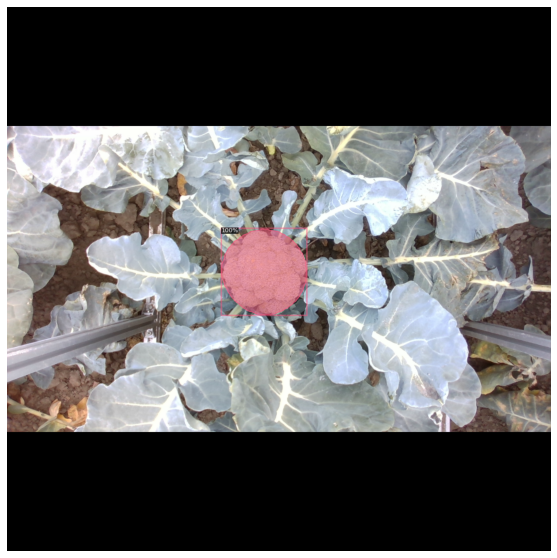

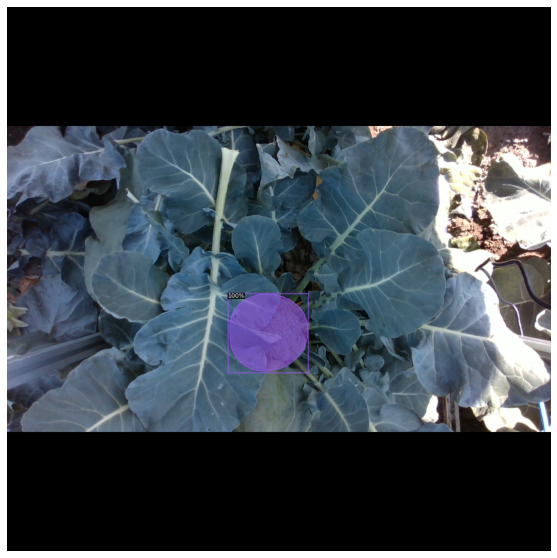

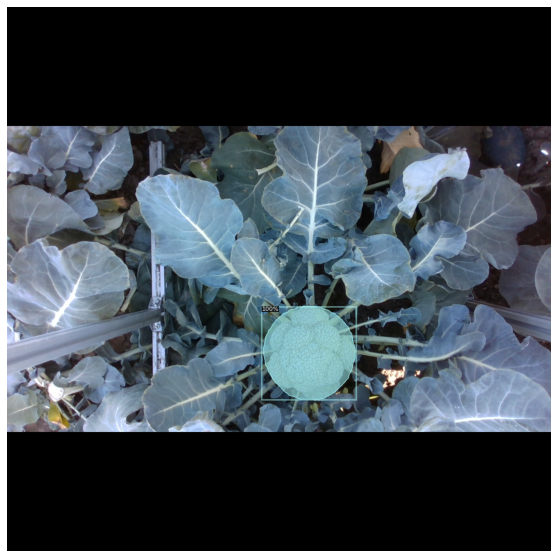

In [13]:
## visualize the amodal mask output
for d in random.sample(dataset_dicts_test, 3):       
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    visualizer = Visualizer(img[:, :, ::-1], metadata=broccoli_amodal_test_metadata, scale=0.8)
    vis = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    imshow(vis.get_image()[:, :, ::-1])

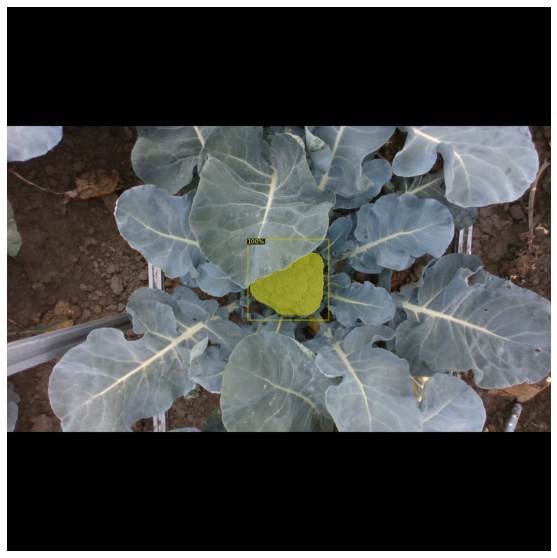

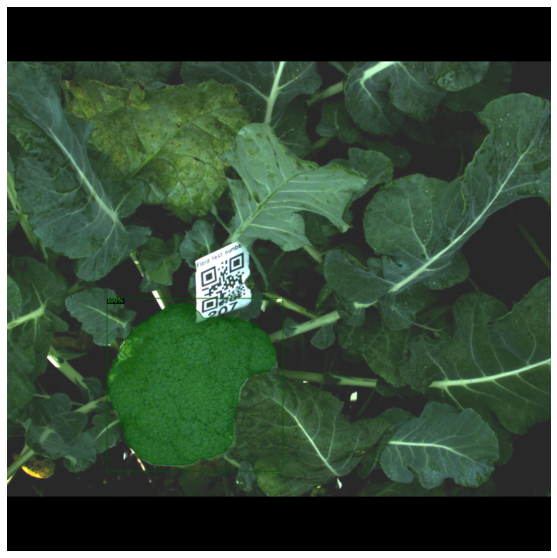

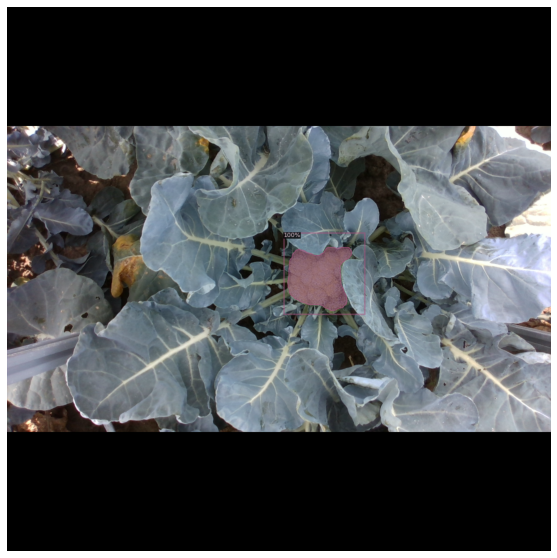

In [14]:
## visualize the visible mask output
for d in random.sample(dataset_dicts_test, 3):       
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    visualizer = Visualizer(img[:, :, ::-1], metadata=broccoli_amodal_test_metadata, scale=0.8)
    vis = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"), 'pred_visible_masks')
    imshow(vis.get_image()[:, :, ::-1])

In [15]:
#  evaluate its performance using AP metric implemented in COCO API.
from detectron2.evaluation import AmodalEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = AmodalEvaluator("broccoli_amodal_test", cfg, False, output_dir="results/20201109_broccoli_amodal_visible")
val_loader = build_detection_test_loader(cfg, "broccoli_amodal_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

[11/10 09:45:47 d2.data.datasets.coco]: Loaded 487 images in COCO format from datasets/train_val_test_files/orcnn/test/annotations.json
[11/10 09:45:47 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  broccoli  | 637          |
|            |              |
[11/10 09:45:47 d2.evaluation.evaluator]: Start inference on 487 images
[11/10 09:45:49 d2.evaluation.evaluator]: Inference done 11/487. 0.1206 s / img. ETA=0:01:04
[11/10 09:45:54 d2.evaluation.evaluator]: Inference done 50/487. 0.1145 s / img. ETA=0:00:56
[11/10 09:45:59 d2.evaluation.evaluator]: Inference done 90/487. 0.1138 s / img. ETA=0:00:50
[11/10 09:46:04 d2.evaluation.evaluator]: Inference done 131/487. 0.1134 s / img. ETA=0:00:44
[11/10 09:46:09 d2.evaluation.evaluator]: Inference done 172/487. 0.1133 s / img. ETA=0:00:39
[11/10 09:46:14 d2.evaluation.evaluator]: Inference done 212/487. 0.1134 s / img. ETA=0:00:34
[11/10 09:46:19 d2.evaluation

OrderedDict([('bbox',
              {'AP': 75.89854693391665,
               'AP50': 95.87106691714652,
               'AP75': 86.88431138855273,
               'APs': nan,
               'APm': 18.655115511551156,
               'APl': 77.2849555984312}),
             ('segm',
              {'AP': 76.26132535639269,
               'AP50': 95.89175804195789,
               'AP75': 86.03332202594666,
               'APs': nan,
               'APm': 22.17821782178218,
               'APl': 77.40911251034238}),
             ('visible',
              {'AP': 82.76149283364244,
               'AP50': 96.96550706949402,
               'AP75': 93.53261302300254,
               'APs': nan,
               'APm': 57.17231723172317,
               'APl': 83.0835753015958})])